In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [ ]:
url = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
df = pd.read_csv(url, header=None)
raw = df.values
data = raw[:, :-1]   # signals
labels = raw[:, -1]  # 1=normal, 0=abnormal :contentReference[oaicite:3]{index=3}

data = (data - data.min())/(data.max() - data.min())


In [ ]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Columns: 141 entries, 0 to 140
dtypes: float64(141)
memory usage: 5.4 MB


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [ ]:
X_train_norm = X_train[y_train==1]
X_test_norm = X_test[y_test==1]
X_test_abn = X_test[y_test==0]

input_dim = X_train_norm.shape[1]

In [ ]:
inp = layers.Input(shape=(input_dim,))
x = layers.Dense(64, activation='relu')(inp)
x = layers.Dense(32, activation='relu')(x)
latent = layers.Dense(16, activation='relu')(x)


In [ ]:
x = layers.Dense(32, activation='relu')(latent)
x = layers.Dense(64, activation='relu')(x)
out = layers.Dense(input_dim, activation='sigmoid')(x)


In [ ]:
autoencoder = models.Model(inputs=inp, outputs=out)


In [ ]:
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [ ]:
history = autoencoder.fit(
    X_train_norm, X_train_norm,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
    shuffle=True,
    verbose=2
)


Epoch 1/30
33/33 - 3s - 80ms/step - loss: 0.0034 - mae: 0.0378 - val_loss: 0.0015 - val_mae: 0.0253
Epoch 2/30
33/33 - 0s - 5ms/step - loss: 0.0011 - mae: 0.0211 - val_loss: 0.0010 - val_mae: 0.0199
Epoch 3/30
33/33 - 0s - 5ms/step - loss: 9.8517e-04 - mae: 0.0196 - val_loss: 9.8353e-04 - val_mae: 0.0196
Epoch 4/30
33/33 - 0s - 5ms/step - loss: 9.5997e-04 - mae: 0.0193 - val_loss: 9.4737e-04 - val_mae: 0.0191
Epoch 5/30
33/33 - 0s - 5ms/step - loss: 9.1136e-04 - mae: 0.0187 - val_loss: 8.7249e-04 - val_mae: 0.0183
Epoch 6/30
33/33 - 0s - 5ms/step - loss: 8.2789e-04 - mae: 0.0177 - val_loss: 7.6633e-04 - val_mae: 0.0170
Epoch 7/30
33/33 - 0s - 6ms/step - loss: 7.4178e-04 - mae: 0.0168 - val_loss: 6.8230e-04 - val_mae: 0.0160
Epoch 8/30
33/33 - 0s - 8ms/step - loss: 6.5044e-04 - mae: 0.0157 - val_loss: 5.8625e-04 - val_mae: 0.0150
Epoch 9/30
33/33 - 0s - 5ms/step - loss: 5.5451e-04 - mae: 0.0147 - val_loss: 5.0610e-04 - val_mae: 0.0141
Epoch 10/30
33/33 - 0s - 5ms/step - loss: 4.8945e-04

In [ ]:
recon_train = autoencoder.predict(X_train_norm)
mse_train = np.mean(np.power(X_train_norm - recon_train, 2), axis=1)
threshold = np.percentile(mse_train, 95)

recon_test = autoencoder.predict(X_test)
mse_test = np.mean(np.power(X_test - recon_test, 2), axis=1)
y_pred = (mse_test > threshold).astype(int)  # 1 indicates anomaly


73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
reconstructions_norm = autoencoder.predict(X_test_norm)
reconstructions_abn  = autoencoder.predict(X_test_abn)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [ ]:
mse_norm = np.mean(np.power(X_test_norm - reconstructions_norm, 2), axis=1)
mse_abn  = np.mean(np.power(X_test_abn - reconstructions_abn, 2), axis=1)


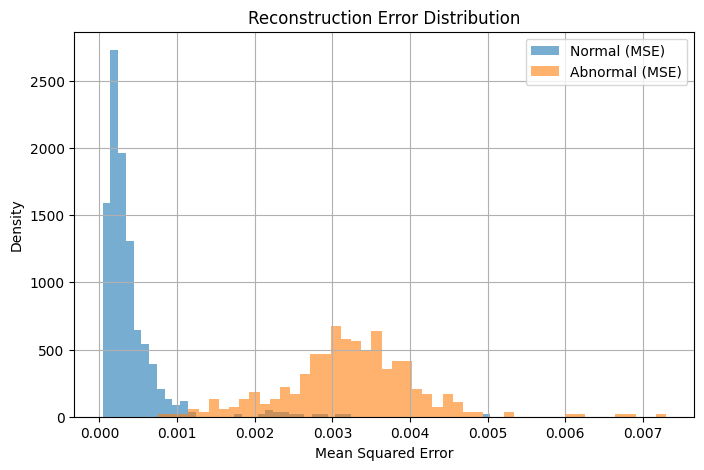

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(mse_norm, bins=50, alpha=0.6, label='Normal (MSE)', density=True)
plt.hist(mse_abn, bins=50, alpha=0.6, label='Abnormal (MSE)', density=True)

plt.title('Reconstruction Error Distribution')
plt.xlabel('Mean Squared Error')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

<Axes: >

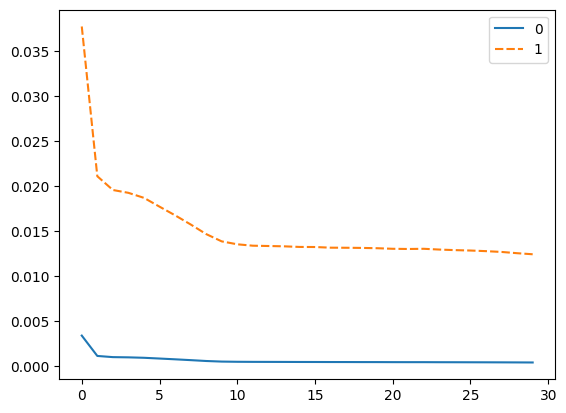

In [ ]:
import seaborn as sns
sns.lineplot((history.history['loss'], history.history['mae']))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print("Threshold:", threshold)
print(confusion_matrix(y_test.astype(int)==0, y_pred))  # abnormal vs predicted
print(classification_report(y_test.astype(int)==0, y_pred))

Threshold: 0.0009401055358076616
[[561  30]
 [  2 407]]
              precision    recall  f1-score   support

       False       1.00      0.95      0.97       591
        True       0.93      1.00      0.96       409

    accuracy                           0.97      1000
   macro avg       0.96      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



In [1]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.xlabel("Epochs")          # X-axis label
plt.ylabel("Loss")            # Y-axis label
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'plt' is not defined